In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from tqdm import tqdm

from  sklearn.preprocessing import MinMaxScaler

import sys
sys.path.append("../utils")
from metrics import compute_recall_at4, compute_normalized_gini, compute_amex_metric

***
## feature groups
- D_* = Delinquency variables
- S_* = Spend variables
- P_* = Payment variables
- B_* = Balance variables
- R_* = Risk variables

In [2]:
data = pd.read_parquet("../data/ext/amex-data-integer-dtypes-parquet-format/train.parquet")
input_cols = data.columns[2:]

categorical_cols = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
numerical_cols = [col for col in input_cols if col not in categorical_cols]

labels = pd.read_csv("../data/raw/train_labels.csv")

display(data)

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0,0.008724,1.006838,0.009228,0.124035,0.0,0.004709,...,-1,-1,-1,0,0,0.0,NaN,0,0.000610,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0,0.004923,1.000653,0.006151,0.126750,0.0,0.002714,...,-1,-1,-1,0,0,0.0,NaN,0,0.005492,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,3,0.021655,1.009672,0.006815,0.123977,0.0,0.009423,...,-1,-1,-1,0,0,0.0,NaN,0,0.006986,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0,0.013683,1.002700,0.001373,0.117169,0.0,0.005531,...,-1,-1,-1,0,0,0.0,NaN,0,0.006527,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947248,0,0.015193,1.000727,0.007605,0.117325,0.0,0.009312,...,-1,-1,-1,0,0,0.0,NaN,0,0.008126,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5531446,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2017-11-05,0.979333,14,0.020818,0.828199,0.003487,0.090743,0.0,0.025139,...,-1,-1,-1,0,0,0.0,NaN,0,0.001498,0
5531447,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2017-12-23,0.984907,10,0.007209,0.812610,0.005904,0.079886,0.0,0.023691,...,-1,-1,-1,0,0,0.0,NaN,0,0.008225,0
5531448,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2018-01-06,0.983019,15,0.013151,0.815422,0.003457,0.100503,0.0,0.012343,...,-1,-1,-1,0,0,0.0,NaN,0,0.006773,0
5531449,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2018-02-06,0.969861,15,0.009855,1.003541,0.005117,0.101802,0.0,0.008578,...,-1,-1,-1,0,0,0.0,NaN,0,0.001168,0


In [3]:
scores = data.groupby("customer_ID")["P_2"].last().reset_index()
scores = pd.merge(scores, labels)
scores

,customer_ID,P_2,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.934745,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0.880519,0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0.880875,0
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0.621776,0
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0.871900,0
...,...,...,...
458908,ffff41c8a52833b56430603969b9ca48d208e7c192c6a4...,0.844229,0
458909,ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fd...,0.831279,0
458910,ffff9984b999fccb2b6127635ed0736dda94e544e67e02...,0.800522,0
458911,ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf38814...,0.754129,1


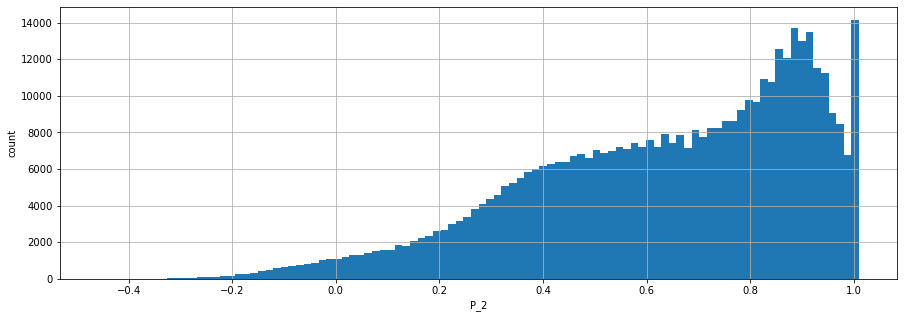

In [4]:
plt.figure(figsize=(15,5))
scores.P_2.hist(bins=100)
plt.xlabel("P_2")
plt.ylabel("count")
plt.show()

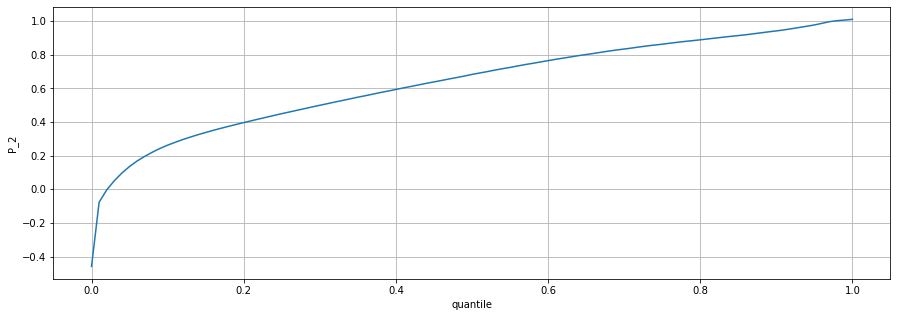

In [5]:
plt.figure(figsize=(15,5))
scores.P_2.quantile(np.arange(0,1.01,0.01)).plot()
plt.grid()
plt.xlabel("quantile")
plt.ylabel("P_2")
plt.show()

In [6]:
scores.groupby("target")["P_2"].mean()

target
0    0.740877
1    0.333752
Name: P_2, dtype: float32

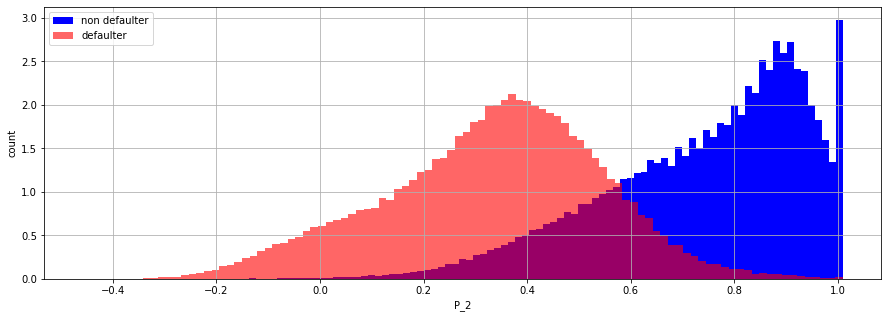

In [7]:
plt.figure(figsize=(15,5))
scores.query("target == 0").P_2.hist(bins=100, color="blue", density=True, label="non defaulter")
scores.query("target == 1").P_2.hist(bins=100, color="red", density=True, alpha=0.6, label="defaulter")
plt.xlabel("P_2")
plt.ylabel("count")
plt.legend(loc="best")
plt.show()

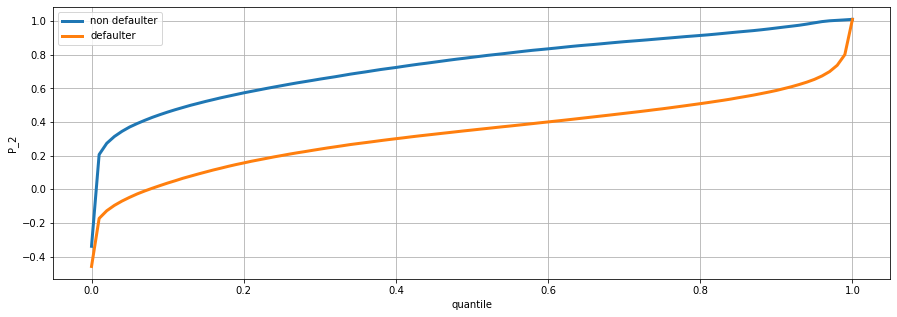

In [8]:
plt.figure(figsize=(15,5))
scores.query("target == 0").P_2.quantile(np.arange(0,1.01,0.01)).plot(label="non defaulter", lw=3)
scores.query("target == 1").P_2.quantile(np.arange(0,1.01,0.01)).plot(label="defaulter", lw=3)
plt.grid()
plt.xlabel("quantile")
plt.ylabel("P_2")
plt.legend(loc="best")
plt.show()

In [9]:
scores.P_2.describe()

count    456479.000000
mean          0.635229
std           0.267534
min          -0.458955
25%           0.449369
50%           0.682590
75%           0.862202
max           1.009998
Name: P_2, dtype: float64

In [10]:
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit((-1*scores.P_2).values.reshape(-1,1))
scores["s"] = scaler.transform((-1*scores.P_2).values.reshape(-1,1)).ravel()

In [11]:
scores = scores.dropna(axis=0, subset=["s"]).reset_index(drop=True)

In [16]:
compute_recall_at4(scores.target.values, scores.s.values)

0.44347143170801734

In [17]:
compute_normalized_gini(scores.target.values, scores.s.values)

0.8333765289005133

In [18]:
compute_amex_metric(scores.target.values, scores.s.values)

0.6384239803042653

***